## About
This notebook generates comparisons of IDPFold based predictions vs. experimental SAXS data, and for the SAME set of sequences compares IDPFold vs.

* CALVADOS2 (as reported by [Tesei et al. 2022](https://open-research-europe.ec.europa.eu/articles/2-94))
* AFRC (a null model reported by [Altson & Ginell et al. 2022](https://pubs.acs.org/doi/full/10.1021/acs.jpcb.3c01619?casa_token=7FU3SE0In7AAAAAA%3AEsuQZBw4VAjsDiRx6okDn1mQeh7KXPWUNDiEx0stVyD7XieqvjswLiT77VY-MQchbXnm9eno4EH-kICv))
* STARLING (this work)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
from scipy.optimize import curve_fit

import matplotlib as mpl

mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1

mpl.rcParams['xtick.major.size'] = 2  # Major tick length for x-axis
mpl.rcParams['xtick.minor.size'] = 0.5   # Minor tick length for x-axis
mpl.rcParams['ytick.major.size'] = 2  # Major tick length for y-axis
mpl.rcParams['ytick.minor.size'] = 0.5   # Minor tick length for y-axis

mpl.rcParams['xtick.major.width'] = 0.375  # Major tick width for x-axis
mpl.rcParams['ytick.major.width'] = 0.375  # Major tick width for y-axis
mpl.rcParams['xtick.minor.width'] = 0.375  # Major tick width for x-axis
mpl.rcParams['ytick.minor.width'] = 0.375  # Major tick width for y-axis
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.375
tqdm
# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)
import pandas as pd

In [2]:
def read_in_idpfold_data(path_to_vals):
    # function to read in the IDPFold Rg data
    
    return_dict = {}
    with open(path_to_vals) as fh:
        lines=fh.read().split('\n')
    fh.close()
    for l in lines[1:]:
        temp=[]
        vals=l.split(',')
        for v in vals[1:]:
            if v != '':
                temp.append(float(v))
        return_dict[vals[0]]=temp
    return return_dict

def rmse(d1,d2):
    """
    Returns the root-mean-squared (RMSE) between two 
    vectors.

    Parameters
    -----------
    d1 : np.ndarray or list
        1D array with one set of values

    d2 : np.ndarray or list
        1D array with another set of values

    Returns
    -----------
    float
        Returns the RMSE     
    
    """

    if len(d1) != len(d2):
        raise ValueError('Input vectors must be same length')
    
    return np.sqrt(np.mean((np.array(d1) - np.array(d2))**2))

def make_figure(d1, d2, xlabel, ylabel, outname, xymin=5, xymax=80, rmse_pos=[12,70],r2_pos=[12,60]):
    """
    Generates and saves a scatter plot comparing two sets of radius of gyration (Rg) values.

    This function creates a consistent figure style for comparing two datasets (d1 and d2)
    using a scatter plot with a diagonal reference line, RMSE annotation, and R² annotation.

    Parameters
    ----------
    d1 : array-like
        First dataset of Rg values (e.g., experimental or reference values).
    d2 : array-like
        Second dataset of Rg values (e.g., predicted or computed values).
    xlabel : str
        Label for the x-axis.
    ylabel : str
        Label for the y-axis.
    outname : str
        Filename (including extension) where the figure will be saved.
    xymin : float, optional
        Minimum value for both x- and y-axis (default is 5).
    xymax : float, optional
        Maximum value for both x- and y-axis (default is 80).
    rmse_pos : list of float, optional
        Coordinates [x, y] for displaying the RMSE annotation (default is [12, 70]).
    r2_pos : list of float, optional
        Coordinates [x, y] for displaying the R² annotation (default is [12, 60]).

    Notes
    -----
    - The function assumes `rmse(d1, d2)` is defined elsewhere and computes the root mean square error.
    - The function computes the coefficient of determination (R²) using Pearson correlation squared.
    - The figure is saved at high resolution (250 DPI) with a size of 2.5 x 2.5 inches.

    Example
    -------
    >>> make_figure(d1, d2, "Experimental Rg", "Predicted Rg", "comparison.pdf")
    """
    
    figure(None, (2.5,2.5), dpi=250)
    
    plt.plot(d1, d2,'ok', ms=3, mew=0, alpha=0.4)
    
    plt.plot([xymin,xymax],[xymin,xymax],'--r', lw=0.4)
    plt.xlabel(xlabel,fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.xlim([xymin,xymax])
    plt.ylim([xymin,xymax])
    
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    
    ccc = rmse(d1,d2)
    r2 = np.power(np.corrcoef(d1,d2)[0][1],2)
    
    plt.text(rmse_pos[0], rmse_pos[1], r"RMSE " +f" = {round(ccc,2)}", fontsize=6)
    plt.text(r2_pos[0], r2_pos[1], r"r$\rm{^2}$ " +f" = {round(r2,2)}", fontsize=6)
    plt.tight_layout()
    plt.savefig(outname)    



In [15]:
all_idpfold_data = read_in_idpfold_data('data/idpfold_sims_of_saxs_seqs_rg_data_June_2025.csv')    
df = pd.read_csv('data/all_comparison_data_WITH_STARTING.csv')

In [16]:
name2nconfs = {}
for k in all_idpfold_data:
    name2nconfs[k] = len(all_idpfold_data[k])

# get
nconf_list = list(set(name2nconfs.values()))
if len(nconf_list) == 1:
    n_conf = nconf_list[0]
else:
    print('Inconsistent numbers of confomers for ensembles, need to consider this on a per-ensemble basis')

In [28]:
ordered_names = list(df['name'])

In [26]:
# we define a couple of name converts due to misatches in names because I'm an idiot...
name_convert = {}
name_convert['A1_LCD_aro_'] =  'A1_Aro_minus'
name_convert['A1_LCD_aro__'] = 'A1_Aro_minus_minus'

# initialize lists for data
idpfold_data = []
saxs_data = []
starling_data = []
calvados_data = []
afrc_data = []

# for each sequence name...
for n in ordered_names:

    # convert name if needed
    if n in name_convert:
        _n = name_convert[n]
    else:
        _n = n


    # extract out values for SAXS, starling, afrc, and CALVADOS
    saxs_value = df.loc[df['name'] == _n, ' saxs'].values[0]
    starling_value = df.loc[df['name'] == _n, ' starling_mps'].values[0]
    afrc_value = df.loc[df['name'] == _n, ' afrc'].values[0]
    calvados_value = df.loc[df['name'] == _n, ' calvados'].values[0]

    try:
        idpfold_value = np.mean(all_idpfold_data[_n])

        idpfold_data.append(idpfold_value)
        saxs_data.append(saxs_value)
        starling_data.append(starling_value)
        afrc_data.append(afrc_value)
        calvados_data.append(calvados_value)
            
    except Exception:
        print(f"Skipping {_n}")


Skipping CortactinCR
Skipping ERalpha_NTD
Skipping Ki_1_57
Skipping Msh6
Skipping Nsp1
Skipping Pertactin_NTD
Skipping PNt
Skipping RpII215_portz
Skipping Swap1
Skipping Swap3
Skipping Swap4
Skipping Swap4_1
Skipping Swap5
Skipping Swap6
Skipping Tau_ht23
Skipping Tau_ht23_AT8_AT100
Skipping Tau_ht23_S214E
Skipping Tau_K23
Skipping Tau_K25
Skipping Tau_K32
Skipping Tau_K32_AT8_AT100
Skipping Tau_K44
Skipping GHR_ICD
Skipping EIF_450_1_249
Skipping Tau_ht35_2022
Skipping syndecan3_ED
Skipping N_FATZ_1
Skipping DeltaN_FATZ_1
Skipping NID_2059_2325


In [27]:
print(f"After filtering, the IDPFold data has {len(saxs_data)} datapoints to compare")

After filtering, the IDPFold data has 104 datapoints to compare


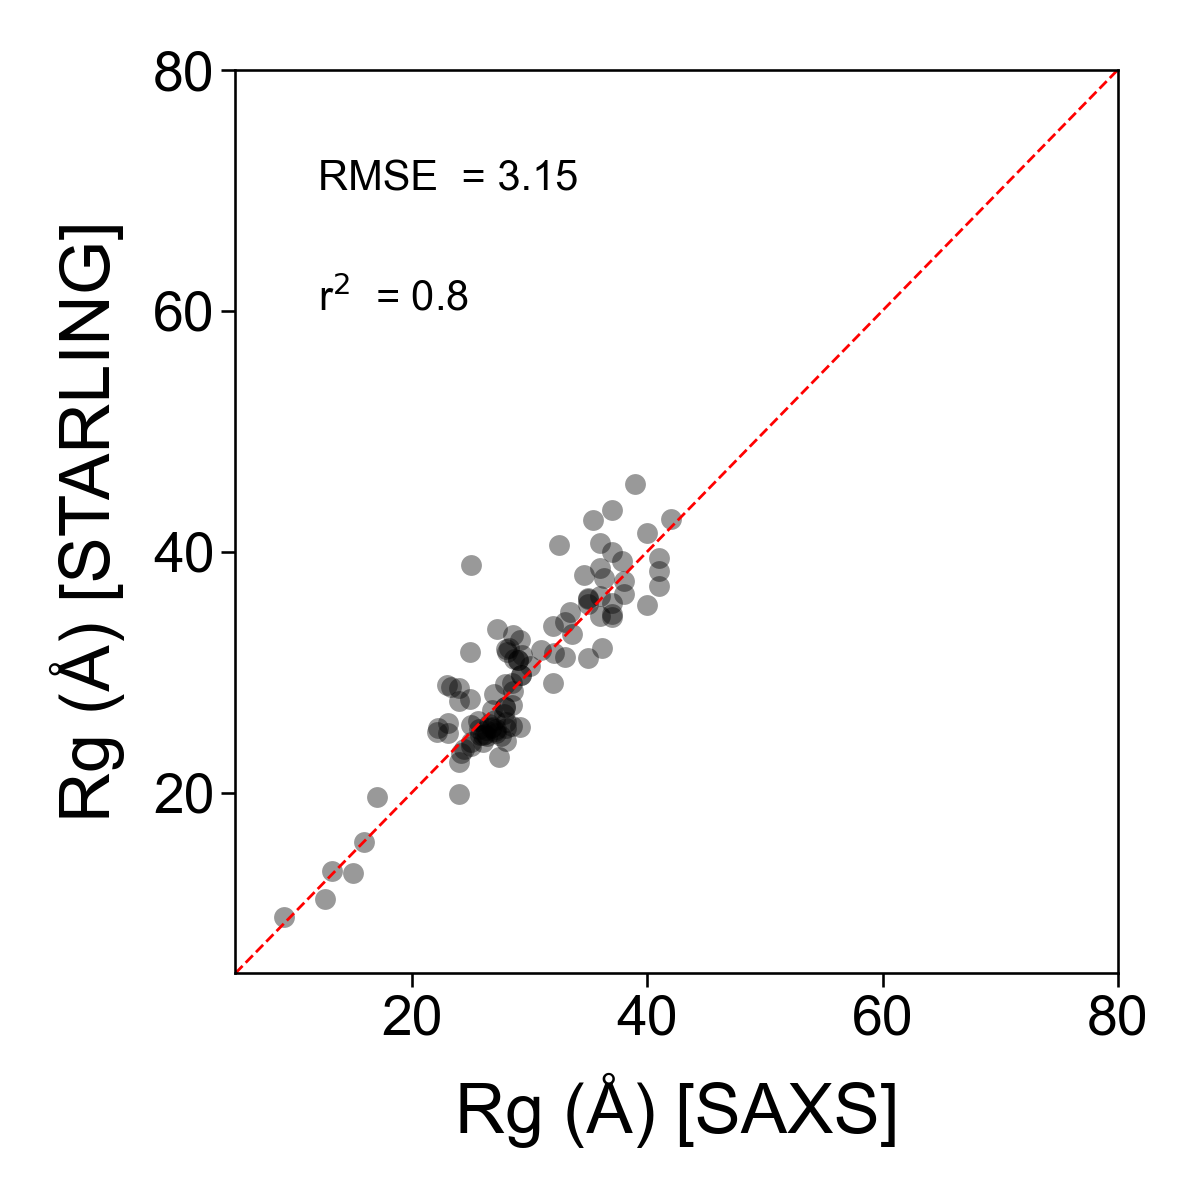

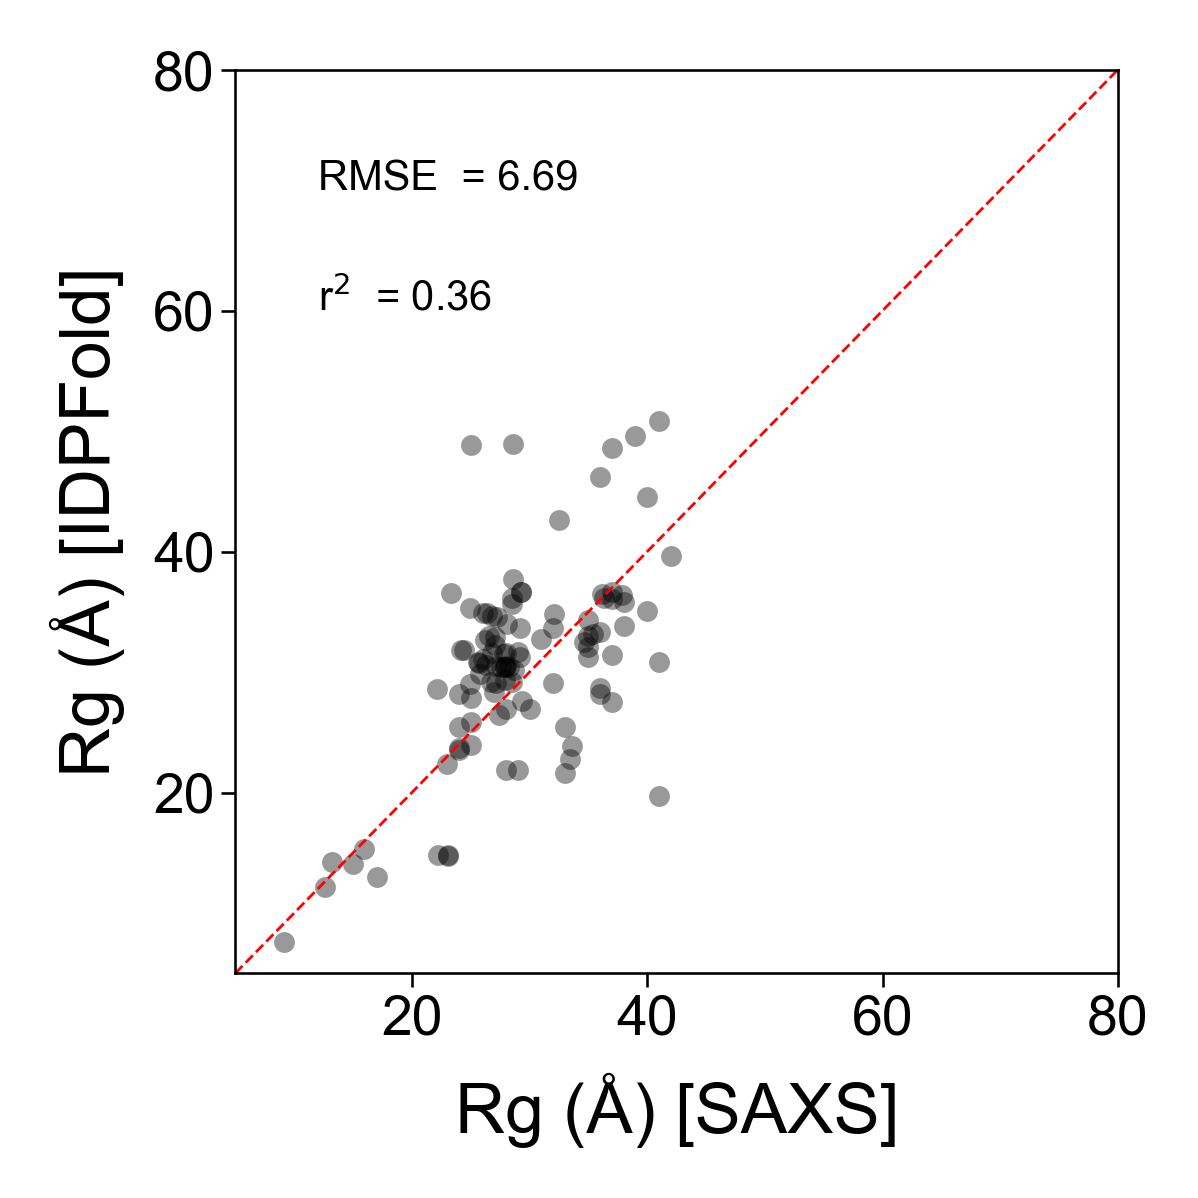

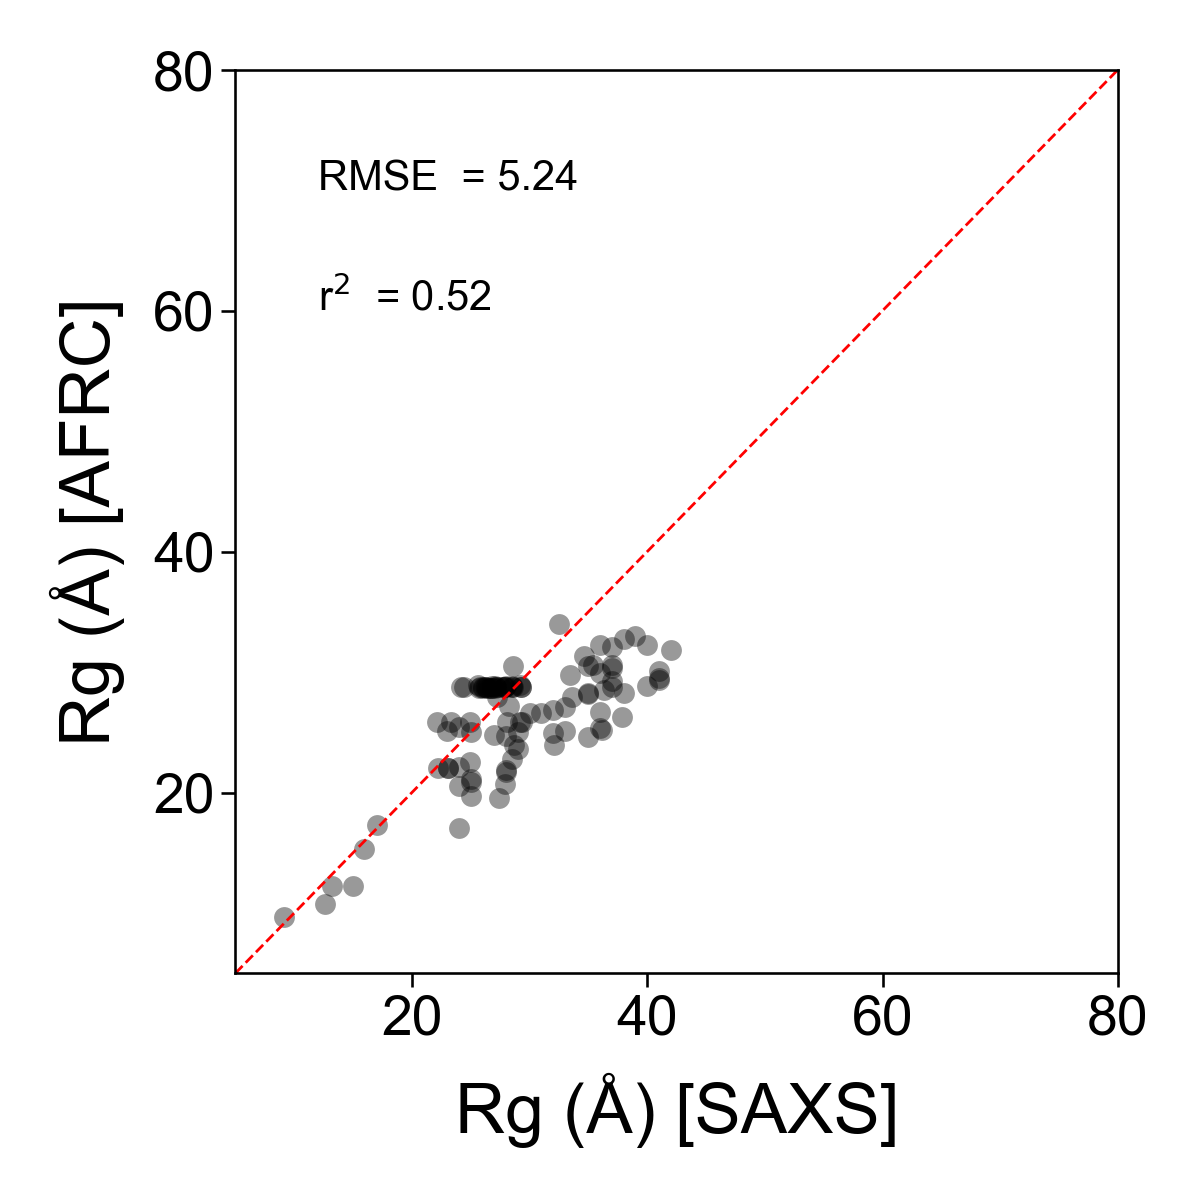

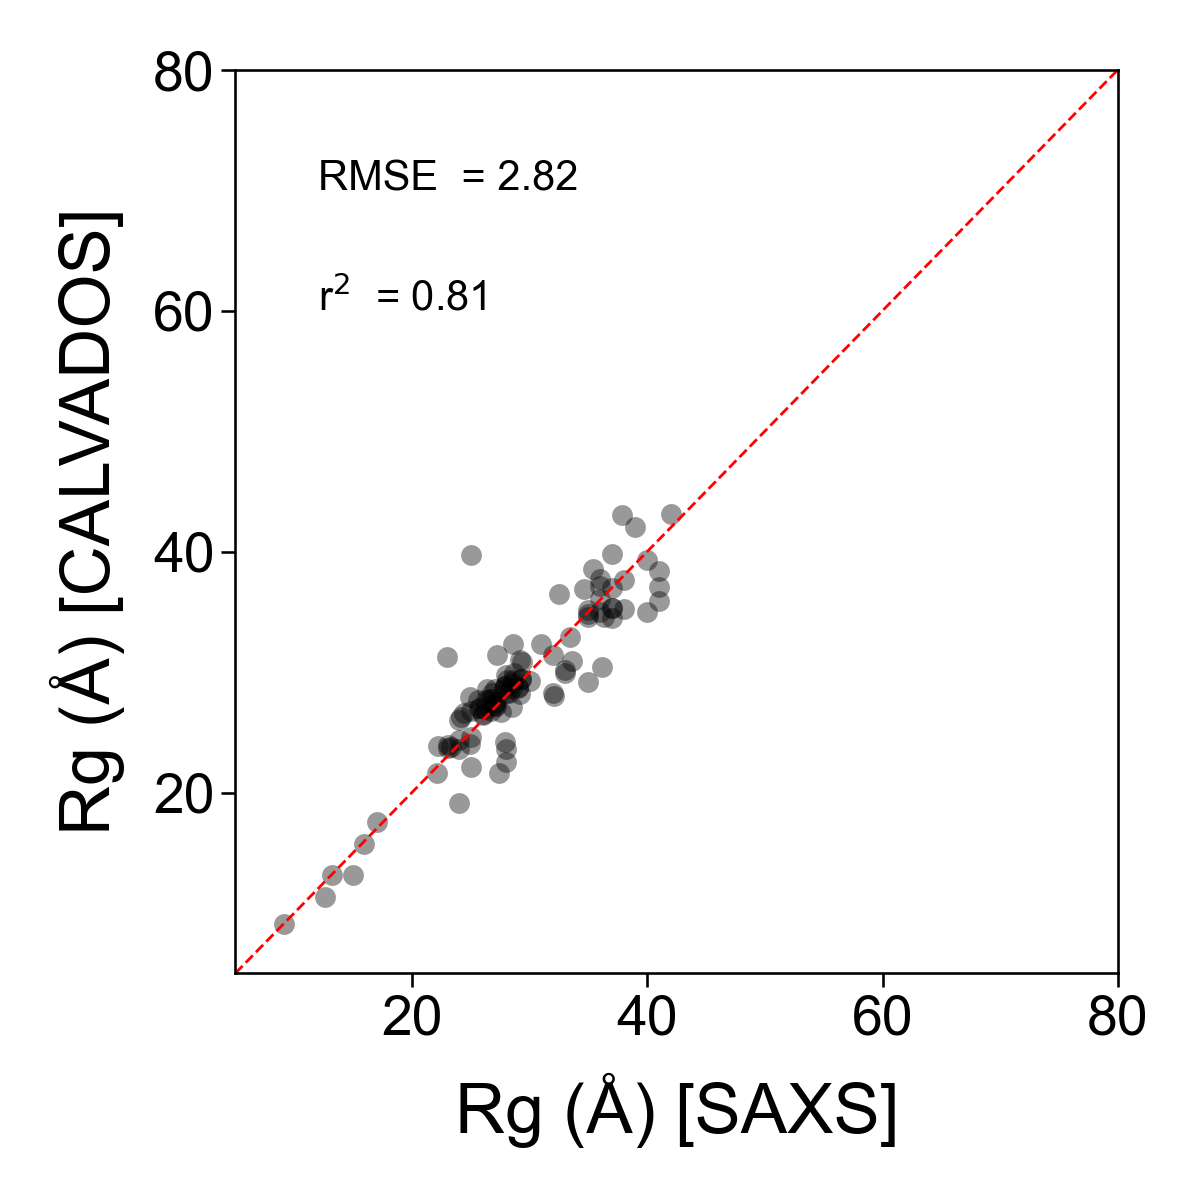

In [19]:
make_figure(saxs_data, starling_data, f"Rg (Å) [SAXS]", f"Rg (Å) [STARLING]", 'figures/saxs_starling.pdf')
make_figure(saxs_data, idpfold_data, f"Rg (Å) [SAXS]", f"Rg (Å) [IDPFold]", 'figures/saxs_idpfold.pdf')
make_figure(saxs_data, afrc_data, f"Rg (Å) [SAXS]", f"Rg (Å) [AFRC]", 'figures/saxs_afrc.pdf')
make_figure(saxs_data, calvados_data, f"Rg (Å) [SAXS]", f"Rg (Å) [CALVADOS]", 'figures/saxs_calvados.pdf')

In [20]:
df_perf = pd.read_csv('data/idpfold_performance.csv')

In [21]:
time_per_conf = np.array(df_perf['Duration(seconds)'] )/n_conf
seq_len = np.array(df_perf['Sequence Length'])

paired = list(zip(seq_len, time_per_conf))
paired_sorted = sorted(paired, key=lambda x: x[0])

# extract back
seq_len_sorted, time_per_conf_sorted = zip(*paired_sorted)



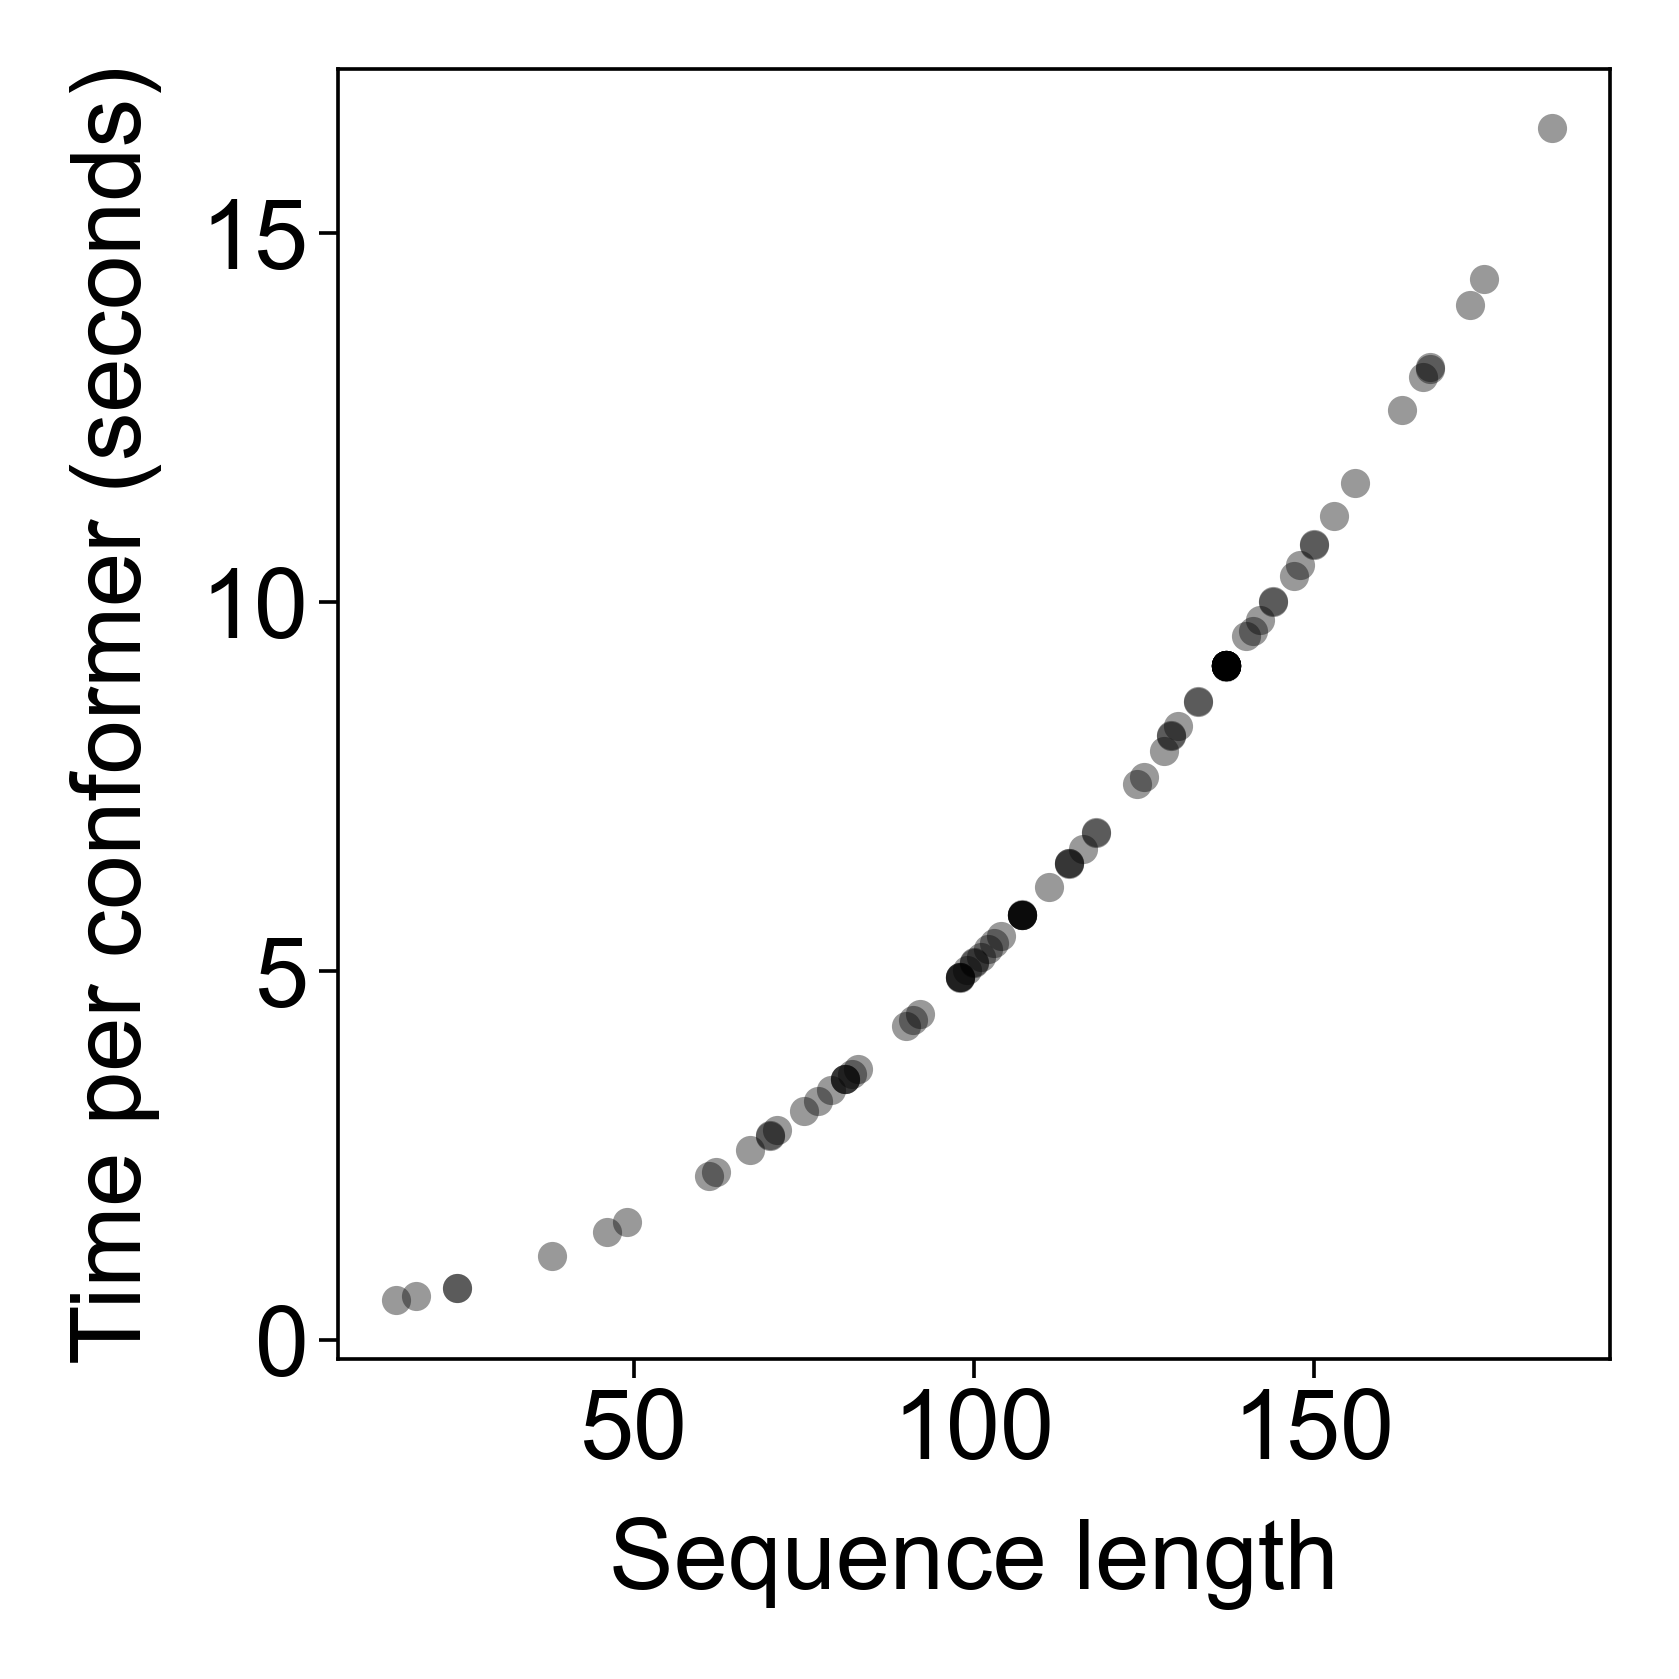

In [22]:
figure(None, (2.5,2.5), dpi=350)
ax = plt.gca()
plt.plot(seq_len_sorted, time_per_conf_sorted,'ok', ms=3, alpha=0.4,mew=0)

plt.xlabel('Sequence length',fontsize=10)
plt.ylabel('Time per conformer (seconds)', fontsize=10)

plt.tight_layout()
plt.savefig('figures/idpfold_performance.pdf')


In [23]:
np.savetxt('outdata/length_vs_time_per_conformer.csv', np.array([seq_len_sorted, time_per_conf_sorted]))